# JMP

Sometimes it's just easier to train a model in JMP using the GUI, rather than writing code. However, porting trained JMP models into Python so they can be used to support further analysis is a common use-case. JENN offers utilities to extract neural net parameters from JMP formulas and load them into a NeuralNet object that Python understands. This notebook provides an example. 

### Libraries

In [1]:
import jenn
import numpy as np 
from jenn.utils import plot

### Synthetic Data

Let's generate some practice data for JMP. We'll use the Rastrigin function, defined as $f(x_1 \cdots x_n) = 10n + \sum_{i=1}^n \left(x_i^2 -10 \cos(2\pi x_i)\right)$

In [2]:
xmin = (-1.0, -1.0)
xmax = (1.5, 1.5)
func = jenn.synthetic.Rastrigin
x_train, y_train, dydx_train = func.sample(m_lhs=100, m_levels=0, lb=xmin, ub=xmax)
x_test, y_test, dydx_test = func.sample(m_lhs=0, m_levels=10, lb=xmin, ub=xmax)

Save to file to it to CSV so it can be loaded in JMP: 

In [3]:
data_train = np.concatenate([x_train, y_train]).T
data_test = np.concatenate([x_test, y_test]).T
data = np.concatenate([data_test, data_test])
np.savetxt("rastrigin.csv", data, delimiter=",", header="x1, x2, y", comments="")

### JMP Formula

The data above was used to train a JMP model offline. Using "Save Profile Formulas" and copy/paste, the resulting equation is given by: 

In [4]:
equation = """6.63968579427224 + 2419.53609389846 * TanH(
	0.5 * (1.17629679110012 + -0.350827466968853 * :x1 + -0.441135986242386 * :x2)
) + 926.302874298947 * TanH(
	0.5 * (0.0532227576798577 + 0.112094306256208 * :x1 + -0.589518737153198 * :x2)
) + -4868.09413385432 * TanH(
	0.5 * (0.669012936934124 + -0.354310015265324 * :x1 + -0.442508530947179 * :x2)
) + 364.826302675917 * TanH(
	0.5 * (0.181903867225405 + -0.400769569147237 * :x1 + -1.82765795570436 * :x2)
) + 69.1044173973596 * TanH(
	0.5 * ((-1.33806951259538) + 5.05831585102242 * :x1 + 0.0768855196783658 * :x2)
) + 1003.55161311844 * TanH(
	0.5 * (0.333506711905318 + -1.21092868596007 * :x1 + -0.094803759612578 * :x2)
) + -105.644746963426 * TanH(
	0.5 * (0.0582830223989066 + -0.758691194673338 * :x1 + 0.193686573458068 * :x2)
) + 28.9924537808578 * TanH(
	0.5 * (1.68489056740589 + 0.203695375799704 * :x1 + 1.55265433664034 * :x2)
) + -16.1485832676648 * TanH(
	0.5 * (0.20830843078032 + 0.293819116867659 * :x1 + -3.34453047341792 * :x2)
) + -40.871646830766 * TanH(
	0.5 * (1.94906272051484 + -0.446838471653994 * :x1 + -7.96896877293616 * :x2)
) + 2.01890616631764 * TanH(
	0.5 * (0.501220953175385 + 1.35505831134419 * :x1 + -0.618548650974262 * :x2)
) + 150.412884466318 * TanH(
	0.5 * (2.21033919158451 + -0.696779972041321 * :x1 + -1.69376087699982 * :x2)
)"""

### JENN Parameters

We can now parse the equation to return the equivalent JENN parameters. 

In [5]:
# ... 

In [6]:
from typing import List, Tuple
from jenn.core.parameters import Parameters
from jenn.model import NeuralNet

In [7]:
def is_float(string: str) -> bool: 
    """Check is string can be converted to float."""
    tokens = string.split(".")
    for token in tokens: 
        if not token.replace("-", "").isnumeric(): 
            return False
    return True

In [8]:
def count_repetitions(char: str, string: str): 
    """Count number of times a character is repeated."""
    count = 0
    for c in string: 
        if c == char: 
            count += 1
    return count 
    

In [9]:
def is_empty(items: List[list]):
    """Return True is all items are empty lists."""
    if not isinstance(items, list): 
        return False
    if all([item == [] for item in items]): 
        return True
    if all([is_empty(item) for item in items]): 
        return True
    return False

In [10]:
def expand(tokens: List[str]): 
    """Expand w * (a * x + b) into (w * a * x + w * b)."""
    updated = []
    number_open_brackets = 0
    factor = 1.0
    skip = 0
    for i, token in enumerate(tokens): 
        if skip > 0: 
            skip -= 1
            continue
        number_open_brackets += count_repetitions("(", token) - count_repetitions(")", token)
        if number_open_brackets == 0:
            if is_float(token) and i < len(tokens) - 2: 
                if tokens[i+1] == "*": 
                    if tokens[i+2] == "(":
                        factor = float(token)
                        skip = 1
                        continue
            if token == ")": 
                continue 
        if number_open_brackets == 1: 
            if token == "(": 
                continue 
            if tokens[i+1] == ")": 
                factor = 1.0
        if is_float(token) and number_open_brackets > 0:
            token = str(float(token) * factor)
        updated.append(token)
    return updated

In [11]:
def remove_unnecessary_brackets(tokens: list[str]): 
    """Remove situations such as ["(", "-1.33806951259538", ")"] where brackets aren't needed."""
    updated = []
    skip = 0
    N = len(tokens)
    for i, token in enumerate(tokens): 
        if skip > 0: 
            skip -= 1
            continue
        if is_float(token): 
            if 0 < i < N: 
                if tokens[i-1] == "(" and tokens[i+1] == ")": 
                    updated = updated[:i-1]
                    skip = 1
                    updated.append(token)
                    continue 
        updated.append(token)
    return updated

In [12]:
def get_node_parameters(tokens: List[str]) -> Tuple[List[float], List[float], List[List[str]]]: 
    """Return bias, weights, and activations associated with node in layer."""
    number_open_brackets = 0 
    N = len(tokens)
    biases = [] 
    weights = []
    activations = []
    activation = []
    for i, token in enumerate(tokens): 
        number_open_brackets += count_repetitions("(", token) - count_repetitions(")", token)
        if number_open_brackets > 0: 
            activation.append(token)
        if number_open_brackets == 0: 
            if activation: 
                activations.append(expand(activation[1:]))  # remove "(" b/c only want inputs of Tanh(...) 
            activation = []
            if is_float(token):
                if tokens[i+1] == "+": 
                    biases.append(float(token))  # there is only one per model in JMP
                elif tokens[i+1] == "*": 
                    weights.append(float(token))
    bias = [sum(biases)]
    return  bias, weights, activations

In [13]:
def get_layer_parameters(nodes: list[list[str]]): 
    """Return bias, weight, activations associated with current layer."""
    layer_biases = []
    layer_weights = []
    for node in nodes:  # for each node in layer
        (
            node_bias, 
            node_weights, 
            layer_activation_inputs,
        ) = get_node_parameters(node) 
        layer_biases.append(node_bias)
        layer_weights.append(node_weights)
    return layer_biases, layer_weights, layer_activation_inputs

In [25]:
def from_jmp(equation: str) -> NeuralNet: 
    equation = equation.replace("(", " ( ")
    equation = equation.replace(")", " ) ")
    equation = equation.replace("+", " + ")
    equation = equation.replace("*", " * ")
    tokens = remove_unnecessary_brackets(equation.split())

    # Last layer 
    (
        layer_bias, 
        layer_weights,  
        previous_layer_activations,  # TanH(...) for each node in layer
    ) = get_layer_parameters([tokens])  

    # Initialize list of neural net parameters for each layer
    biases = [layer_bias]
    weights = [layer_weights]
    
    # Loop through previous layers
    # while not is_empty(previous_layer_activations):  
    if True:
        (
            layer_bias, 
            layer_weights, 
            previous_layer_activations,
        ) = get_layer_parameters(nodes=previous_layer_activations)  
        biases.append(layer_bias)
        weights.append(layer_weights)
    
    N = len(biases)  # number of layers 
    b = [np.array(b) for b in reversed(biases)]
    W = [np.array(W) for W in reversed(weights)]

    kwargs = dict(
        layer_sizes=[W[0].shape[1]] + [W[i].shape[0] for i in range(N)],
        hidden_activation="tanh", 
        output_activation="linear",
    )

    neural = NeuralNet(**kwargs)
    neural.parameters.initialize()

    for i in range(1, N+1): 
        neural.parameters.W[i][:] = W[i-1]
        neural.parameters.b[i][:] = b[i-1]
    
    return neural

In [30]:
jmp_model = from_jmp(equation)

[array([[-0.17541373, -0.22056799],
       [ 0.05604715, -0.29475937],
       [-0.17715501, -0.22125427],
       [-0.20038478, -0.91382898],
       [ 2.52915793,  0.03844276],
       [-0.60546434, -0.04740188],
       [-0.3793456 ,  0.09684329],
       [ 0.10184769,  0.77632717],
       [ 0.14690956, -1.67226524],
       [-0.22341924, -3.98448439],
       [ 0.67752916, -0.30927433],
       [-0.34838999, -0.84688044]]), array([[ 2.41953609e+03,  9.26302874e+02, -4.86809413e+03,
         3.64826303e+02,  6.91044174e+01,  1.00355161e+03,
        -1.05644747e+02,  2.89924538e+01, -1.61485833e+01,
        -4.08716468e+01,  2.01890617e+00,  1.50412884e+02]])]


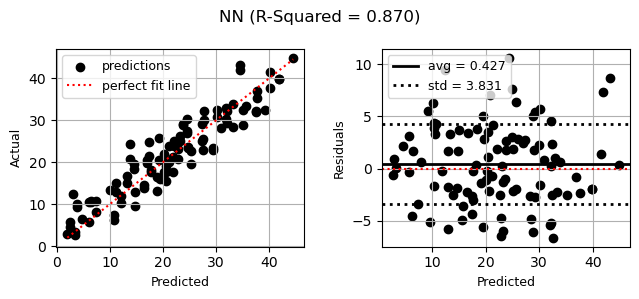

In [31]:
plot.goodness_of_fit(
    y_true=y_test, 
    y_pred=jmp_model.predict(x_test),
    title="NN"
)